# Projeto Marinha do Brasil

### Autor: Natanael Junior (natmourajr@gmail.com)
### Laboratorio de Processamento de Sinais - UFRJ

In [2]:
import os
import pickle
import numpy as np
import time

import keras.callbacks as callbacks
from keras import backend as K
from keras.utils import np_utils
from keras.models import load_model
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
from keras.models import load_model

import sklearn
import sklearn.metrics
from sklearn import preprocessing
from sklearn.externals import joblib

from Functions import TrainParameters as trnparams
from Functions import TrainFunctions
from Functions import FunctionsDataVisualization

import multiprocessing 

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

analysis_name = 'NeuralNetwork'
data_path = os.getenv('OUTPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')

base_results_path = '%s/%s'%(results_path,analysis_name)
pict_results_path = '%s/pictures_files'%(base_results_path)
files_results_path = '%s/output_files'%(base_results_path)

# For multiprocessing purpose
num_processes = multiprocessing.cpu_count()

# Read data
# Check if LofarData has created...
m_time = time.time()

database = '4classes'
n_pts_fft = 1024
decimation_rate = 3
spectrum_bins_left = 400
development_flag = False
development_events = 400

if not os.path.exists('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left)):
    print 'No Files in %s/%s\n'%(data_path,database)
else:
    #Read lofar data
    [data,trgt,class_labels] = joblib.load('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                                           (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left))


    m_time = time.time()-m_time
    print 'Time to read data file: '+str(m_time)+' seconds'

    # correct format
    all_data = data
    all_trgt = trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))
    
    # Process data
    # unbalanced data to balanced data with random data creation of small classes

    # Same number of events in each class
    qtd_events_biggest_class = 0
    biggest_class_label = ''

    for iclass, class_label in enumerate(class_labels):
        if sum(all_trgt==iclass) > qtd_events_biggest_class:
            qtd_events_biggest_class = sum(all_trgt==iclass)
            biggest_class_label = class_label
        print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
    print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)

    balanced_data = {}
    balanced_trgt = {}

    from Functions import DataHandler as dh
    m_datahandler = dh.DataHandlerFunctions()

    for iclass, class_label in enumerate(class_labels):
        if development_flag:
            class_events = all_data[all_trgt==iclass,:]
            if len(balanced_data) == 0:
                balanced_data = class_events[0:development_events,:]
                balanced_trgt = (iclass)*np.ones(development_events)
            else:
                balanced_data = np.append(balanced_data,
                                          class_events[0:development_events,:], 
                                          axis=0)
                balanced_trgt = np.append(balanced_trgt,(iclass)*np.ones(development_events))
        else:
            if len(balanced_data) == 0:
                class_events = all_data[all_trgt==iclass,:]
                balanced_data = m_datahandler.CreateEventsForClass(
                    class_events,qtd_events_biggest_class-(len(class_events)))
                balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
            else:
                class_events = all_data[all_trgt==iclass,:]
                created_events = (m_datahandler.CreateEventsForClass(all_data[all_trgt==iclass,:],
                                                                     qtd_events_biggest_class-
                                                                     (len(class_events))))
                balanced_data = np.append(balanced_data,created_events,axis=0)
                balanced_trgt = np.append(balanced_trgt,
                                          (iclass)*np.ones(created_events.shape[0]),axis=0)
        
    all_data = balanced_data
    all_trgt = balanced_trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

Using Theano backend.
/home/vinicius.mello/.virtualenvs/sonarenvSatigny/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Time to import all libraries: 3.81469726562e-05 seconds
Time to read data file: 1.77291107178 seconds
Qtd event of 0 is 12939
Qtd event of 1 is 29352
Qtd event of 2 is 11510
Qtd event of 3 is 23760

Biggest class is 1 with 29352 events
DataHandler Class: CreateEventsForClass
Original Size: (12939, 400)
DataHandler Class: CreateEventsForClass
Original Size: (29352, 400)
DataHandler Class: CreateEventsForClass
Original Size: (11510, 400)
DataHandler Class: CreateEventsForClass
Original Size: (23760, 400)


In [3]:
%%time
# load parameters

analysis_str = 'NeuralNetwork'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
os.remove(trn_params_folder)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=2,
                                                         hidden_activation='softplus',
                                                         output_activation='softmax',
                                                         n_epochs=500,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

n_folds = 2
CVO = trnparams.ClassificationFolds(folder=results_path,
                                    n_folds=n_folds,
                                    trgt=all_trgt,
                                    dev=development_flag, verbose=False)



CPU times: user 10.8 ms, sys: 1.79 ms, total: 12.6 ms
Wall time: 108 ms


## Treinamento com processamento paralelo

In [3]:
%%time
# To train on multiple cores sweeping the number of folds
def trainFold(ifold):
    ineuron = 20
    return TrainFunctions.NeuralTrainFunction(data=all_data,
                            trgt=all_trgt,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=development_flag)
# To train on multiple cores sweeping the number of neurons
def trainNeuron(ineuron):
    for ifold in range(len(CVO)):
        TrainFunctions.NeuralTrainFunction(data=all_data,
                            trgt=all_trgt,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=development_flag)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 5.96 µs


In [4]:
%time
p = multiprocessing.Pool(processes=num_processes)
start_time = time.time()
folds = range(len(CVO))
neurons = range(0, 105, 5)
# To train on multiple cores sweeping the number of folds
#results = p.map(trainFold, folds)

# To train on multiple cores sweeping the number of neurons
results = p.map(trainNeuron, neurons)

p.close()
p.join()
end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
Neuron: 75 - Fold 1 of 2 Folds -  Init 1 of 2 Inits
Neuron: 65 - Fold 1 of 2 Folds -  Init 1 of 2 Inits
Neuron: 90 - Fold 1 of 2 Folds -  Init 1 of 2 Inits
Neuron: 85 - Fold 1 of 2 Folds -  Init 1 of 2 Inits
Neuron: 70 - Fold 1 of 2 Folds -  Init 1 of 2 Inits
Neuron: 95 - Fold 1 of 2 Folds -  Init 1 of 2 Inits
Neuron: 100 - Fold 1 of 2 Folds -  Init 1 of 2 Inits
Neuron: 80 - Fold 1 of 2 Folds -  Init 1 of 2 Inits
Neuron: 65 - Fold 1 of 2 Folds -  Init 2 of 2 Inits
Neuron: 70 - Fold 1 of 2 Folds -  Init 2 of 2 Inits
Neuron: 75 - Fold 1 of 2 Folds -  Init 2 of 2 Inits
Neuron: 80 - Fold 1 of 2 Folds -  Init 2 of 2 Inits
Neuron: 85 - Fold 1 of 2 Folds -  Init 2 of 2 Inits
Neuron: 90 - Fold 1 of 2 Folds -  Init 2 of 2 Inits
Neuron: 95 - Fold 1 of 2 Folds -  Init 2 of 2 Inits
Neuron: 100 - Fold 1 of 2 Folds -  Init 2 of 2 Inits
Neuron: 70 - Fold 2 of 2 Folds -  Init 1 of 2 Inits
Neuron: 65 - Fold 2 of 2 Folds -  Init 1 of 2 Init

In [5]:
print "%.2f minutes"%(end_time/60)
print "%.2f hours"%(end_time/3600)
print trn_params.get_params_str()

0.00 minutes
0.00 hours
2_inits_mapstd_norm_500_epochs_256_batch_size_softplus_hidden_activation_softmax_output_activation


# Análises com variação de Neurônios

/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/NeuralNetwork/RawData_2_folds_2_inits_mapstd_norm_500_epochs_256_batch_size_softplus_hidden_activation_softmax_output_activation_0_neurons_fold_0_model.h5
/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/NeuralNetwork/RawData_2_folds_2_inits_mapstd_norm_500_epochs_256_batch_size_softplus_hidden_activation_softmax_output_activation_5_neurons_fold_0_model.h5
/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/NeuralNetwork/RawData_2_folds_2_inits_mapstd_norm_500_epochs_256_batch_size_softplus_hidden_activation_softmax_output_activation_10_neurons_fold_0_model.h5
/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/NeuralNetwork/RawData_2_folds_2_inits_mapstd_norm_500_epochs_256_batch_size_softplus_hidden_activation_softmax_output_activation_15_neurons_fold_0_model.h5
/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/NeuralNetwork/RawData_2_folds_2_inits_

/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/NeuralNetwork/RawData_2_folds_2_inits_mapstd_norm_500_epochs_256_batch_size_softplus_hidden_activation_softmax_output_activation_80_neurons_fold_1_model.h5
/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/NeuralNetwork/RawData_2_folds_2_inits_mapstd_norm_500_epochs_256_batch_size_softplus_hidden_activation_softmax_output_activation_85_neurons_fold_1_model.h5
/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/NeuralNetwork/RawData_2_folds_2_inits_mapstd_norm_500_epochs_256_batch_size_softplus_hidden_activation_softmax_output_activation_90_neurons_fold_1_model.h5
/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/NeuralNetwork/RawData_2_folds_2_inits_mapstd_norm_500_epochs_256_batch_size_softplus_hidden_activation_softmax_output_activation_95_neurons_fold_1_model.h5
/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/NeuralNetwork/RawData_2_folds_2_init

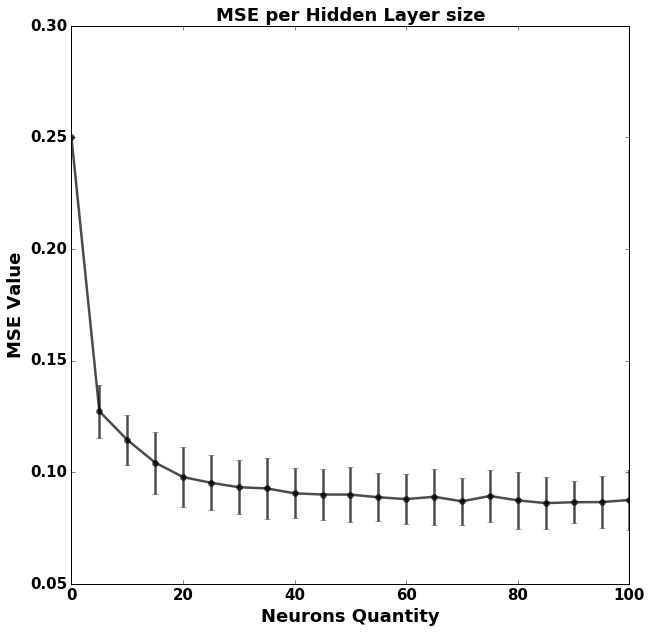

In [8]:
# Neuron variation x MSE

# generate analysis data
save_path=results_path

analysis_str = 'NeuralNetwork'
model_prefix_str = 'RawData'

current_analysis = 'mse'

analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name, current_analysis)

if os.path.exists(analysis_file_name):
    os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):
    trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
    
    if not os.path.exists(trn_params_folder):
        trn_params = trnparams.NeuralClassificationTrnParams(n_inits=4,
                                                             hidden_activation='softplus',
                                                             output_activation='softmax',
                                                             n_epochs=500,
                                                             patience=50,
                                                             batch_size=256,
                                                             verbose=False)
        trn_params.save(trn_params_folder)
    else:
        trn_params = trnparams.NeuralClassificationTrnParams()
        trn_params.load(trn_params_folder)

    params_str = trn_params.get_params_str()
    n_folds = 2
    CVO = trnparams.ClassificationFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)

    neurons_mat = range(0,105,5)

    mse_mat = np.zeros([n_folds,len(neurons_mat)])

    for ifold in range(len(CVO)):
        train_id, test_id = CVO[ifold]

        # normalize data based in train set
        if trn_params.params['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

        norm_data = scaler.transform(all_data[test_id,:])

        for ineuron,neuron_value in enumerate(neurons_mat):     
            
            model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                       model_prefix_str,
                                                       n_folds,
                                                       params_str,
                                                       neuron_value)
            
            if not development_flag:        
                file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
            print file_name
                
            if not os.path.exists(file_name):
                def trainFold(ifold):
                    ineuron = neuron_value
                    return TrainFunctions.NeuralTrainFunction(data=all_data,
                                            trgt=all_trgt,
                                            ifold=ifold,
                                            n_folds=n_folds, 
                                            n_neurons=ineuron,
                                            trn_params=trn_params, 
                                            save_path=results_path,
                                            dev=development_flag)
            model = load_model(file_name)
            output = model.predict(norm_data)
            mse = sklearn.metrics.mean_squared_error(trgt_sparse[test_id,:], np.round(output))
            mse_mat[ifold,ineuron] = mse
            
    joblib.dump([mse_mat,neurons_mat],analysis_file_name,compress=9)
else:
    [mse_mat,neurons_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

# Plot Mean Squared Error
ax.errorbar(neurons_mat,np.mean(mse_mat,axis=0),
            np.std(mse_mat,axis=0),fmt='o-',
            color='k',alpha=0.7,linewidth=2.5)

ax.set_title('MSE per Hidden Layer size',fontsize=18,weight='bold')
ax.set_xlabel('Neurons Quantity',fontsize=18,weight='bold')
ax.set_ylabel('MSE Value',fontsize=18,weight='bold') 

# Save the figure
plt.savefig(pict_results_path+'/'+current_analysis+'_'+trn_params.get_params_str()+'.pdf')
print "Topology (%s)"%trn_params.get_params_str()

Topology (2_inits_mapstd_norm_500_epochs_256_batch_size_softplus_hidden_activation_softmax_output_activation)


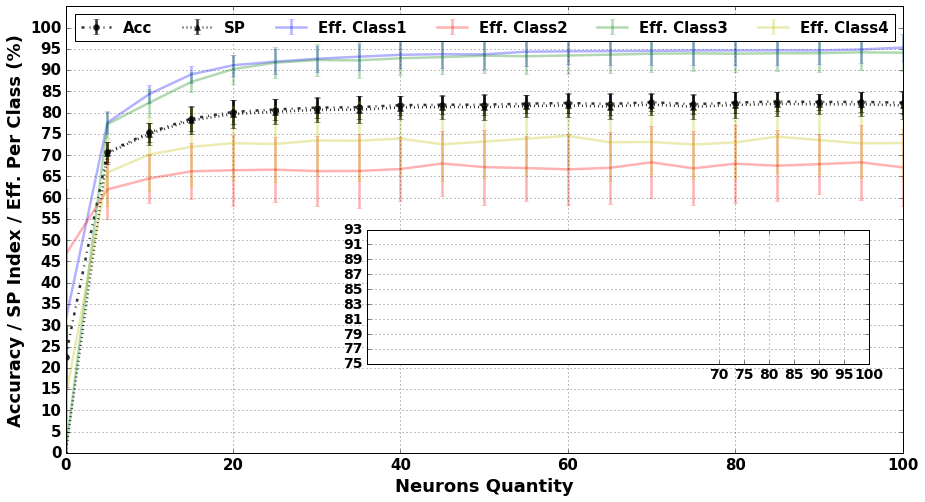

In [10]:
# Neuron variation x Accuracy / Sp index / Efficiency

# generate analysis data
save_path=results_path

analysis_str = 'NeuralNetwork'
model_prefix_str = 'RawData'
current_analysis = 'accuracy_sp_index_effiencyPerClass'

analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name,current_analysis)

if os.path.exists(analysis_file_name):
    os.remove(analysis_file_name)

# Check if the analysis has already been done
if not os.path.exists(analysis_file_name):
    trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
    
    # If the model to be analysed has others parameters, delete the trnparams.jbl file and run this cell again
    if not os.path.exists(trn_params_folder):
        trn_params = trnparams.NeuralClassificationTrnParams(n_inits=4,
                                                             hidden_activation='softplus',
                                                             output_activation='softmax',
                                                             n_epochs=500,
                                                             patience=50,
                                                             batch_size=256,
                                                             verbose=False)
        trn_params.save(trn_params_folder)
    else:
        trn_params = trnparams.NeuralClassificationTrnParams()
        trn_params.load(trn_params_folder)

    params_str = trn_params.get_params_str()
    
    # Choose how many points to be displayed in the plot
    #neurons_mat = range(0,65,5)
    
    n_folds = len(CVO)
    
    # Initialize the matrices
    acc_mat = np.zeros([n_folds,len(neurons_mat)])
    sp_index_mat = np.zeros([n_folds,len(neurons_mat)])
    efficiency_mat = np.zeros(shape=[n_folds, len(neurons_mat), len(class_labels)])
    
    for ifold in range(len(CVO)):
        train_id, test_id = CVO[ifold]

        # normalize data based in train set
        if trn_params.params['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

        norm_data = scaler.transform(all_data[test_id,:])

        for ineuron,neuron_value in enumerate(neurons_mat):     
            if neuron_value == 0:
                neuron_value = 1
            
            model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                       model_prefix_str,
                                                       n_folds,
                                                       params_str,
                                                       neuron_value)

            if not development_flag:        
                file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
            if trn_params.params['verbose']:
                print file_name
                
            # Check if the model has been trained    
            if not os.path.exists(file_name):
                def trainFold(ifold):
                    ineuron = neuron_value
                    return TrainFunctions.NeuralTrainFunction(data=all_data,
                                            trgt=all_trgt,
                                            ifold=ifold,
                                            n_folds=n_folds, 
                                            n_neurons=ineuron,
                                            trn_params=trn_params, 
                                            save_path=results_path,
                                            dev=development_flag)
            # Load weigths
            model = load_model(file_name)
            output = model.predict(norm_data)
            # Get accuracy matrix
            acc = sklearn.metrics.accuracy_score(trgt_sparse[test_id], np.round(output))
            acc_mat[ifold,ineuron] = acc 
            # Get sp_index matrix
            num_classes = len(class_labels)
            efficiency = sklearn.metrics.recall_score(trgt_sparse[test_id], np.round(output), average=None)
            sp_index = np.sqrt(np.sum(efficiency)/num_classes * np.power(np.prod(efficiency), 1.0/float(num_classes)))
            sp_index_mat[ifold,ineuron] = sp_index
            #Get efficiency per class matrix
            efficiency = sklearn.metrics.recall_score(trgt_sparse[test_id], np.round(output), average=None)
            efficiency_mat[ifold,ineuron] = efficiency
            
    joblib.dump([acc_mat,sp_index_mat,efficiency_mat,neurons_mat],analysis_file_name,compress=9)
else:
    [acc_mat,sp_index_mat,efficiency_mat,neurons_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

acc_mat = 100 * acc_mat
sp_index_mat = 100 * sp_index_mat
efficiency_mat = 100 * efficiency_mat

fig, ax = plt.subplots(figsize=(15,8),nrows=1, ncols=1)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

colors = ['b', 'r', 'g', 'y']
markers = ['d-', '>--', '8-', 's--']

# Plot Accuracy
ax.errorbar(neurons_mat,np.mean(acc_mat,axis=0),
            np.std(acc_mat,axis=0),fmt='o-.',
            color='k',alpha=0.8,linewidth=2.5, label='Acc')
# Plot SP index
ax.errorbar(neurons_mat,np.mean(sp_index_mat,axis=0),
            np.std(sp_index_mat,axis=0),fmt='^:',
            color='k',alpha=0.8,linewidth=2.5, label='SP')
# Plot effiency per class
for iclass in range(len(class_labels)):
    ax.errorbar(neurons_mat,np.mean(efficiency_mat[:,:,iclass],axis=0),
                np.std(efficiency_mat[:,:,iclass],axis=0),fmt='-',
                color=colors[iclass],alpha=0.3,linewidth=2.5, label='Eff. %s'%class_labels[iclass])

ax.set_xlabel('Neurons Quantity',fontsize=18,weight='bold')
ax.set_ylabel('Accuracy / SP Index / Eff. Per Class (%)',fontsize=18,weight='bold')
ax.set_ylim([0, 105])
ax.set_yticks(range(0,105,5))

ax.grid()

# Set legend box location
ax.legend(loc='upper right', ncol=6)

# Subplot in the bigger plot
# It is used to give emphasis in points of some range
# These are in unitless percentages of the figure size. (0,0 is bottom left)
rect = [0.36, 0.2, 0.6, 0.3] #x_location, y_location, width, height

ax1 = FunctionsDataVisualization.add_subplot_axes(ax,rect)

# Plot SP index
ax1.errorbar(neurons_mat[70:105:5],np.mean(sp_index_mat[:,70:105:5],axis=0),
            np.std(sp_index_mat[:,70:105:5],axis=0),fmt='^:',
            color='k',alpha=0.8,linewidth=2.5)
# Plot Accuracy 
ax1.errorbar(neurons_mat[70:105:5],np.mean(acc_mat[:,70:105:5],axis=0),
            np.std(acc_mat[:,70:105:5],axis=0),fmt='o-',
            color='k',alpha=0.8,linewidth=2.5)

ax1.set_yticks(range(75,100,2))
ax1.set_yticklabels(range(75,100,2), fontsize=14)

ax1.set_xticks(range(70,105,5))
ax1.set_xticklabels(range(70,105,5), fontsize=14)
ax1.set_ylim([75,93])
ax1.grid()

# Save the figure
plt.savefig(pict_results_path+'/'+current_analysis+'_'+trn_params.get_params_str()+'.pdf')
print "Topology (%s)"%trn_params.get_params_str()

Results for 100 neurons (2_inits_mapstd_norm_500_epochs_256_batch_size_softplus_hidden_activation_softmax_output_activation)


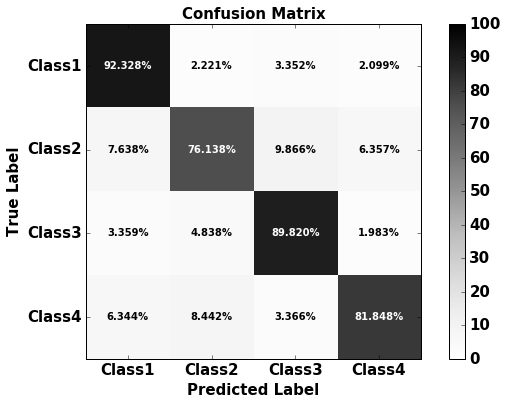

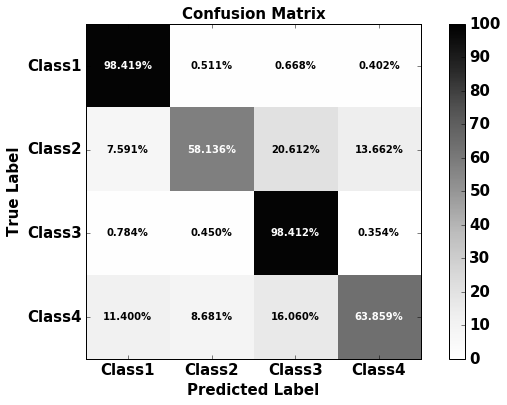

In [13]:
# Confusion Matrix

%matplotlib inline  

current_analysis = 'confusion_matrix'

# Choose Topology
ineuron = 100

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='relu',
                                                         output_activation='softmax',
                                                         n_epochs=300,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
print "Results for %i neurons (%s)"%(ineuron, params_str)
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_aspect(1)

    from sklearn.metrics import confusion_matrix

    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data[test_id,:])

    model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                   model_prefix_str,
                                                   n_folds,
                                                   params_str,
                                                   ineuron)

    if not development_flag:        
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    # Check if the topology has already been trained    
    if not os.path.exists(file_name):
        def trainFold(ifold):
            return TrainFunctions.NeuralTrainFunction(data=all_data,
                                    trgt=all_trgt,
                                    ifold=ifold,
                                    n_folds=n_folds, 
                                    n_neurons=ineuron,
                                    trn_params=trn_params, 
                                    save_path=results_path,
                                    dev=development_flag)
    # load weights into new model
    model = load_model(file_name)
    output = np.round(model.predict(norm_data))
    
    all_output = np.argmax(output,axis=1)
    cm = confusion_matrix(all_trgt[test_id], all_output)
    cm_normalized = 100.*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im =ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

    width, height = cm_normalized.shape

    for x in xrange(width):
        for y in xrange(height):
            if cm_normalized[x][y] < 50.:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center')
            else:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center',color='white')

    ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
    fig.colorbar(im)
    tick_marks = np.arange(len(labels))
    ax.xaxis.set_ticks(tick_marks)
    ax.xaxis.set_ticklabels(labels)

    ax.yaxis.set_ticks(tick_marks)
    ax.yaxis.set_ticklabels(labels)

    ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
    ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
    
    plt.savefig(pict_results_path+'/'+current_analysis+'_'+'%i_neurons_fold_%i_'%(ineuron,ifold)+trn_params.get_params_str()+'.pdf')

Results for 100 neurons (2_inits_mapstd_norm_500_epochs_256_batch_size_softplus_hidden_activation_softmax_output_activation)


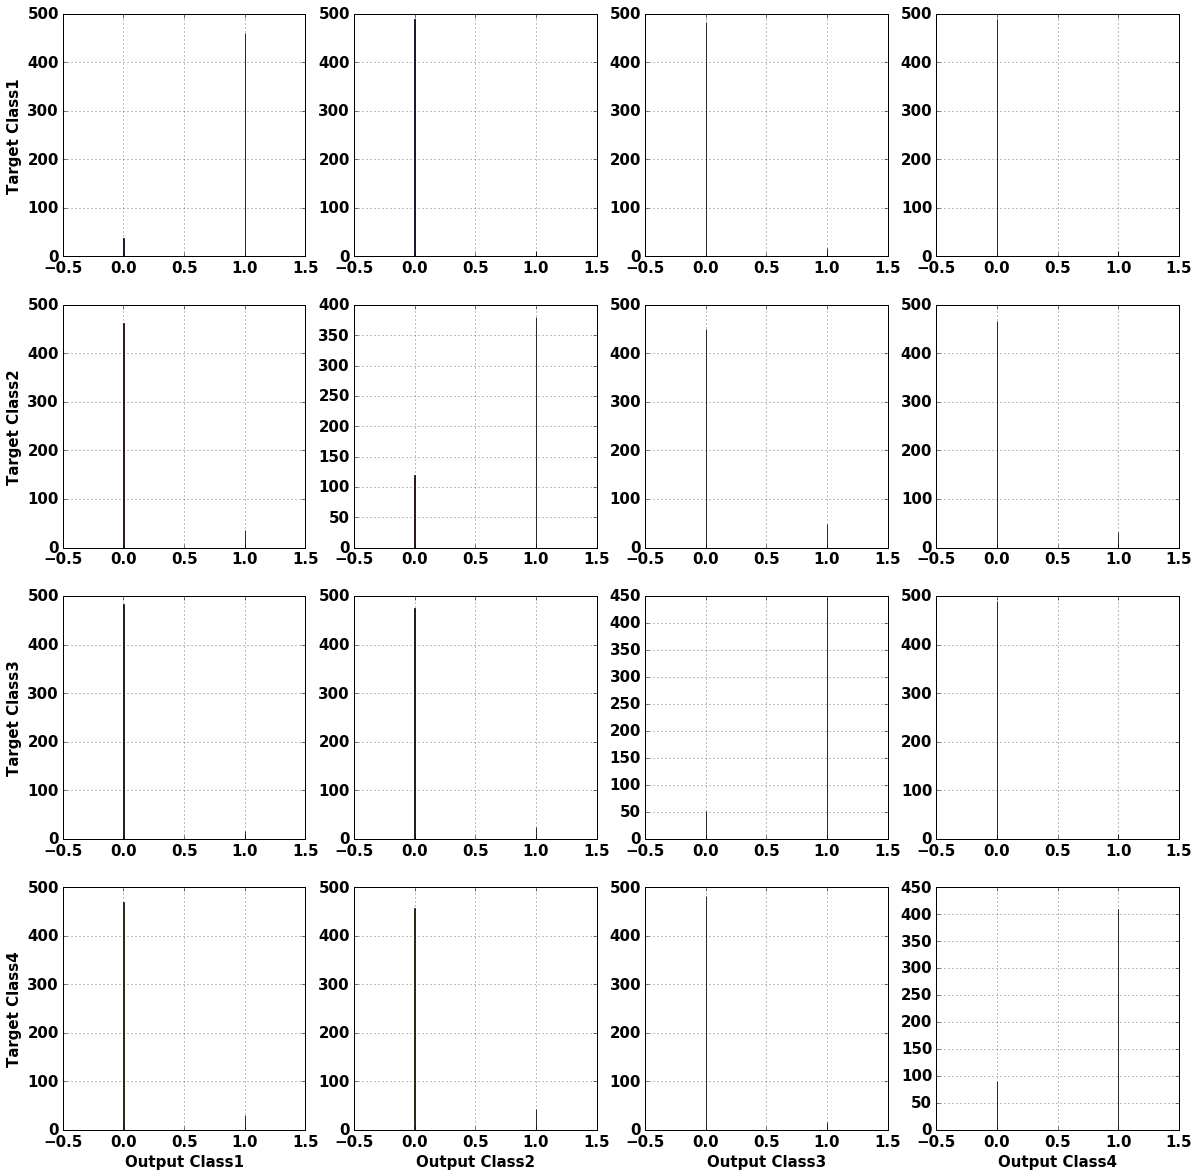

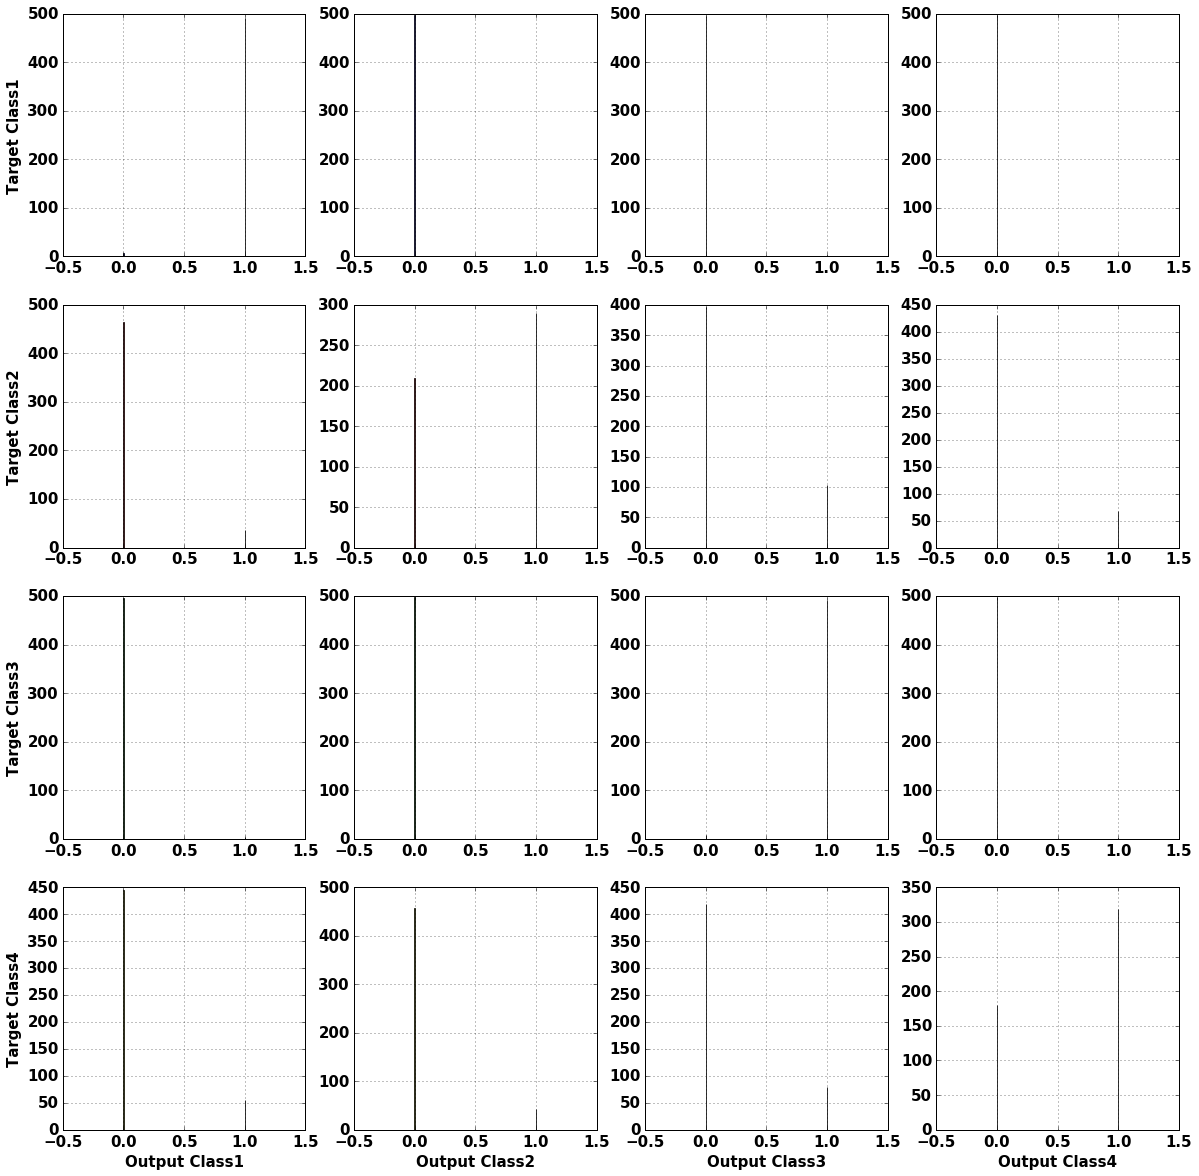

In [14]:
# Histogram
%matplotlib inline  

current_analysis = 'histogram'

# Choose Topology
ineuron = 100

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='relu',
                                                         output_activation='softmax',
                                                         n_epochs=300,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
print "Results for %i neurons (%s)"%(ineuron, params_str)
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data[test_id,:])

    model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                   model_prefix_str,
                                                   n_folds,
                                                   params_str,
                                                   ineuron)

    if not development_flag:        
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    # Check if the topology has already been trained    
    if not os.path.exists(file_name):
        NeuralTrainFunction(data=all_data,
                            trgt=all_trgt,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=development_flag)  
        
    # load weights into new model
    model = load_model(file_name)
    output = np.round(model.predict(norm_data))
   
    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5, 1000)

    m_colors = ['b', 'r', 'g', 'y']
    
    for i_target in range(trgt_sparse[test_id].shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[all_trgt[test_id]==i_target,i_output]

            n, bins, patches = ax[i_target,i_output].hist(m_pts,bins=m_bins,
                                                          fc=m_colors[i_target],
                                                          alpha=0.8, normed=1)

            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()
    plt.savefig(pict_results_path+'/'+current_analysis+'_'+'%i_neurons_fold_%i_'%(ineuron,ifold)+trn_params.get_params_str()+'.pdf')

In [ ]:
# Kernel Density
%matplotlib inline  

current_analysis = 'kernel_density'

# Choose Topology
ineuron = 30

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='relu',
                                                         output_activation='softmax',
                                                         n_epochs=300,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
print "Results for %i neurons (%s)"%(ineuron, params_str)
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data[test_id,:])

    model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                   model_prefix_str,
                                                   n_folds,
                                                   params_str,
                                                   ineuron)

    if not development_flag:        
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    # Check if the topology has already been trained    
    if not os.path.exists(file_name):
        NeuralTrainFunction(data=all_data,
                            trgt=all_trgt,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=development_flag)  
        
    # load weights into new model
    model = load_model(file_name)
    output = np.round(model.predict(norm_data))
   
    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5,100)

    m_colors = ['b', 'r', 'g', 'y']

    kernel = 'gaussian' # other kernels: 'gaussian', 'tophat', 
                        #'epanechnikov', 'exponential', 'linear', 'cosine'
    for i_target in range(trgt_sparse[test_id].shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[all_trgt[test_id]==i_target,i_output]

            kde = KernelDensity(kernel=kernel,algorithm='auto',
                                bandwidth=0.5).fit(m_pts[:, np.newaxis])
            log_dens_x = kde.score_samples(m_bins[:, np.newaxis])
            ax[i_target,i_output].plot(m_bins, np.exp(log_dens_x),
                                       color=m_colors[i_target],linewidth=2.0)
            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()

In [18]:
# Classification Report
# Choose Topology
ineuron = 100

acc = np.zeros([4, 4]);

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='relu',
                                                         output_activation='softmax',
                                                         n_epochs=300,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
print "Results for %i neurons (%s)"%(ineuron, params_str)
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)
    norm_data = norm_data[test_id,:]
    model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                   model_prefix_str,
                                                   n_folds,
                                                   params_str,
                                                   ineuron)

    if not development_flag:        
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    # Check if the topology has already been trained    
    if not os.path.exists(file_name):
        NeuralTrainFunction(data=all_data,
                            trgt=all_trgt,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=development_flag)  
        
    # load weights into new model
    model = load_model(file_name)
    # Winner takes all
    output = np.round(model.predict(norm_data))
    
    num_classes = len(class_labels.keys())
    
    efficiency = sklearn.metrics.recall_score(trgt_sparse[test_id], np.round(output), average=None)
    sp_index = np.sum(efficiency)/num_classes * np.power(np.prod(efficiency), 1/num_classes)
    sp_index = np.sqrt(sp_index)
    acc[ifold] = efficiency
    precision = sklearn.metrics.precision_score(trgt_sparse[test_id], np.round(output), average=None)
    f1_score = sklearn.metrics.f1_score(trgt_sparse[test_id], np.round(output), average=None)
    
    print '\tPrecision\tEfficiency\tF1_Score'
    for iclass in range(num_classes):
        print '%s:\t%f\t%f\t%f\n'%(class_labels[iclass], precision[iclass], efficiency[iclass],f1_score[iclass])
    print 'SP index: %f\n'%sp_index
    

Results for 100 neurons (2_inits_mapstd_norm_500_epochs_256_batch_size_softplus_hidden_activation_softmax_output_activation)
	Precision	Efficiency	F1_Score
Class1:	0.849093	0.922050	0.884069

Class2:	0.830842	0.761379	0.794596

Class3:	0.844134	0.898201	0.870329

Class4:	0.886887	0.818479	0.851311

SP index: 0.921969

	Precision	Efficiency	F1_Score
Class1:	0.840384	0.984056	0.906563

Class2:	0.857746	0.581357	0.693011

Class3:	0.724941	0.984124	0.834880

Class4:	0.815808	0.638594	0.716404

SP index: 0.892767



## Análise Paramétrica

In [ ]:
# analysis example - number epochs

from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks

from keras.utils import np_utils
from keras.models import load_model

from Functions import TrainParameters as trnparams

# generate analysis data
save_path=results_path

analysis_str = 'NeuralNetwork'
model_prefix_str = 'RawData'
parameter = 'epochs'

analysis_file_name='%s/%s/%s_%s_sweep.jbl'%(results_path,analysis_str,analysis_name, parameter)

if not os.path.exists(analysis_file_name):
    
    epochs_mat = range(1,10,1)
    mse_mat = np.zeros([n_folds,len(epochs_mat)])
    
    for iepochs,epochs_value in enumerate(epochs_mat):       
        print "Number of Epochs:", epochs_value
        trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='softplus',
                                                         output_activation='softmax',
                                                         patience=50,
                                                         batch_size=512,
                                                         n_epochs=epochs_value)
    
        params_str = trn_params.get_params_str()
        print "params_str: ",params_str
        n_folds = 2
        CVO = trnparams.ClassificationFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)


        for ifold in range(len(CVO)):
            train_id, test_id = CVO[ifold]

            # normalize data based in train set
            if trn_params.params['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
            elif trn_params.params['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
            elif trn_params.params['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

            norm_data = scaler.transform(all_data)
            
            neurons =10
            NeuralTrainFunction(data=all_data, trgt=all_trgt, ifold=ifold, n_folds=n_folds, 
                                n_neurons=neurons, trn_params=trn_params, 
                                save_path=results_path,dev=development_flag)

            # turn targets in sparse mode
            trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))


            model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                           model_prefix_str,
                                                           n_folds,
                                                           params_str,
                                                           neurons)

            model = Sequential()
            model.add(Dense(neurons, input_dim=data.shape[1], init="uniform"))
            model.add(Activation(trn_params.params['hidden_activation']))
            model.add(Dense(trgt_sparse.shape[1], init="uniform")) 
            model.add(Activation(trn_params.params['output_activation']))

            if not development_flag:        
                file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
                
            print 'Model name: %s'%(file_name)
            model = load_model(file_name)
            output = model.predict(norm_data)
            mse = np.mean(np.sum((trgt_sparse-output)**2))
            mse_mat[ifold,iepochs] = mse
    joblib.dump([mse_mat,epochs_mat],analysis_file_name,compress=9)
else:
    [mse_mat,epochs_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

ax.errorbar(epochs_mat,np.mean(mse_mat,axis=0),
            np.std(mse_mat,axis=0),fmt='o-',
            color='k',alpha=0.7,linewidth=2.5)
ax.set_title('MSE per Number of Epochs',fontsize=18,weight='bold')
ax.set_xlabel('Epochs',fontsize=18,weight='bold')
ax.set_ylabel('MSE Value',fontsize=18,weight='bold')